In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np

import py21cmfast as p21c
from astropy.cosmology import Planck18
from scipy import interpolate

sys.path.append("..")
from dm21cm.dm_params import DMParams
from dm21cm.evolve import evolve
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
from darkhistory.main import evolve as evolve_DH

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## DMParam

In [2]:
dm_params = DMParams(
    mode = 'decay',
    primary = 'phot_delta',
    m_DM = 1.2e10,
    lifetime = 1e25,
)

tf_version = 'zf01'

In [2]:
dm_params = DMParams(
    mode = 'decay',
    primary = 'phot_delta',
    m_DM = 1.2e10,
    lifetime = 1e50,
)

tf_version = 'zf01'

## DarkHistory

In [3]:
from darkhistory.config import load_data
load_data('dep_tf', prefix=f'/n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_{tf_version}')
load_data('ics_tf', prefix=f'/n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_{tf_version}');

****** Loading transfer functions... ******
Using data at /n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_zf01
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [ ]:
run_name = 'dhc_noinj_noHe'

soln = evolve_DH(
    DM_process=dm_params.mode, mDM=dm_params.m_DM,
    primary=dm_params.primary,
    sigmav=dm_params.sigmav, lifetime=dm_params.lifetime,
    struct_boost=dm_params.struct_boost,
    start_rs=3000, end_rs=4.+1, coarsen_factor=12, verbose=1,
    # use fake reionization to get case-A recomb. coeff.
    reion_switch=True, reion_rs=47.,
    photoion_rate_func=[lambda x: 0., lambda x: 0., lambda x: 0.],
    photoheat_rate_func=[lambda x: 0., lambda x: 0., lambda x: 0.],
    cross_check_21cmfast=True,
    debug_no_bath=False,
)

pickle.dump(soln, open(f"run_info/{run_name}_dh_soln.p", 'wb'))

In [5]:
run_name = 'dhc_noinj_noHe'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
dh_xe_interp_func = lambda z: interpolate.interp1d(dh_soln['rs']-1, dh_soln['x'][:, 0])(z).item()
hep_N_arr = np.array([s.N for s in dh_soln['highengphot']])
hep_rs_arr = np.array([s.rs for s in dh_soln['highengphot']])
dh_bath_N_interp_func = interpolate.interp1d(hep_rs_arr-1, hep_N_arr, axis=0)

In [6]:
! mkdir $P21C_CACHE_DIR/dhc_noinj_noHe
! cp -v run_info/dhc_noinj_noHe_dh_soln.p $P21C_CACHE_DIR/dhc_noinj_noHe/dh_init_soln.p

'run_info/dhc_noinj_noHe_dh_soln.p' -> '/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_noinj_noHe/dh_init_soln.p'


In [ ]:
return_dict = evolve(
    run_name = 'dhc_noinj_noHe',
    z_start = 45.,
    z_end = 5.,
    zplusone_step_factor = 1.01,
    dm_params = dm_params,
    enable_elec = False,
    tf_version = tf_version,
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 16,
            BOX_LEN = 16 * 4, # [conformal Mpc]
            N_THREADS = 32,
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = Planck18.Om0,
            OMb = Planck18.Ob0,
            POWER_INDEX = Planck18.meta['n'],
            #SIGMA_8 = Planck18.meta['sigma8'],
            SIGMA_8 = 1e-8,
            hlittle = Planck18.h,
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    use_tqdm = False,
    debug_flags = ['uniform_xray'],
    debug_xray_multiplier = 1.,
    debug_astro_params = p21c.AstroParams(
        L_X = 0. # log10 value
    ),
    save_dir='run_info',
    custom_YHe = 1e-6,
    #debug_dhc_delta_fixed=True,
    #debug_dhc_DH_xe_func=dh_xe_interp_func,
    #dh_bath_N_interp_func=dh_bath_N_interp_func,
)

## compare

In [8]:
def plot_global(dh_soln, soln):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    color_dict = {
        'DH' : 'k',
        '21' : 'r',
    }

    z_plot_start = 50.
    i_z_st = np.argmin(np.abs(dh_soln['rs']-1 - z_plot_start))
    ax = axs[0,0]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['Tm'][i_z_st:]/phys.kB, color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['T_k'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['T_k'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$T_k$ [K]', title='Gas temperature')
    ax.legend()

    ax = axs[0,1]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DH HII')
    #ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 1], color='b', label='DH HeII')
    ax.plot(soln['z'], soln['x_e'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['x_e'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$x_e$', title='$x_e$')
    ax.legend()

    ax = axs[0,2]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DH HII')
    #ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 1], color='b', label='DH HeII')
    ax.plot(soln['z'], soln['1-x_H'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['1-x_H'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$1-x_H$', title='$1-x_H$')
    ax.legend()

    ax = axs[0,3]
    ax.plot(soln['z'], soln['T_b'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log')
    ax.set(xlabel='$z$', ylabel='$T_b$ [K]', title='Brightness temperature')

    ax = axs[1,0]
    dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_bath_engs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['E_phot'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['E_phot'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$E$ [eV/Bavg]', title='Bath energy')

    ax = axs[1,1]
    dh_fs = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['f_heat'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{heat}$')

    ax = axs[1,2]
    dh_fs = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['f_ion'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{ion}$')

    ax = axs[1,3]
    dh_fs = dh_soln['f']['low']['exc'] + dh_soln['f']['high']['exc']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['f_exc'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{exc}$')

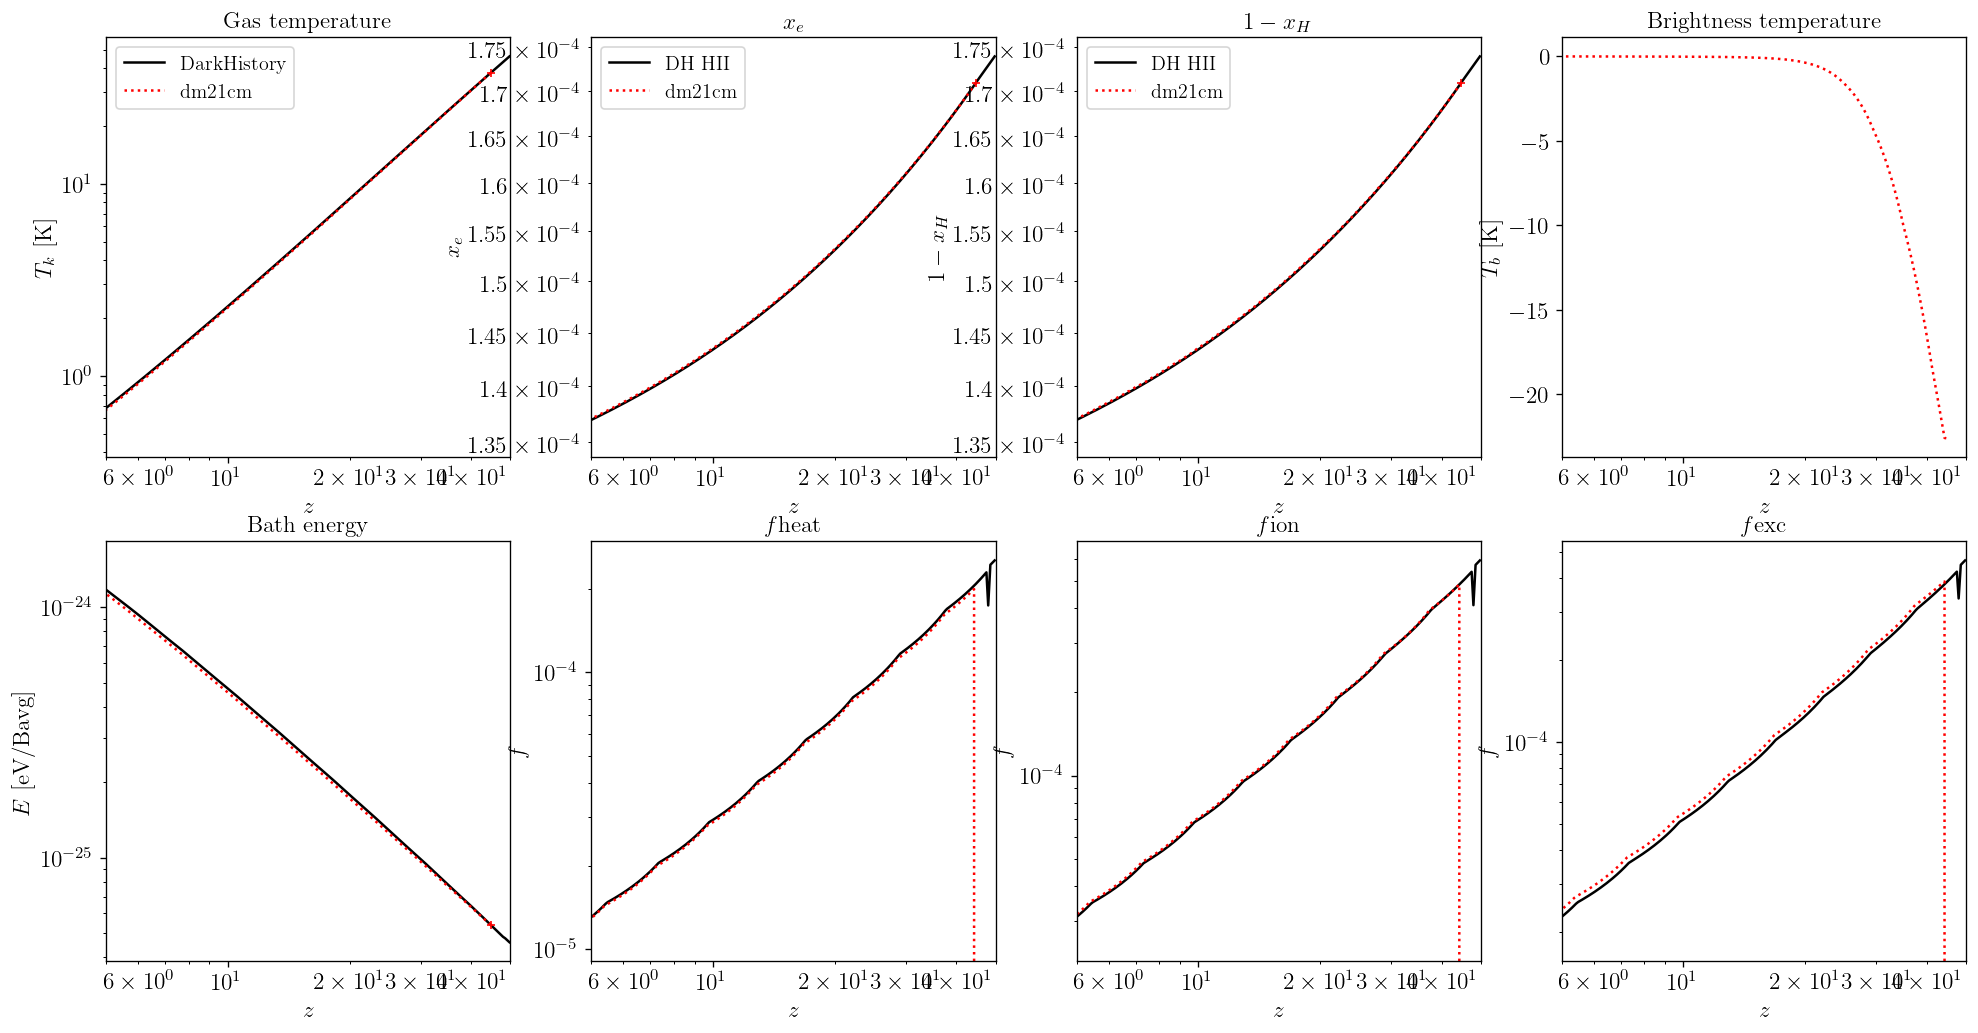

In [9]:
run_name = 'dhc_noinj_noHe'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
run_name = 'dhc_phph'
soln = np.load(f"run_info/{run_name}_records.npy", allow_pickle=True).item()
plot_global(dh_soln, soln)

In [10]:
from dm21cm.utils import load_h5_dict
abscs = load_h5_dict(f"../data/abscissas/abscs_{tf_version}.h5")

In [11]:
abscs.keys()

dict_keys(['dep_c', 'dlnz', 'elecEk', 'nBs', 'photE', 'rs', 'x'])

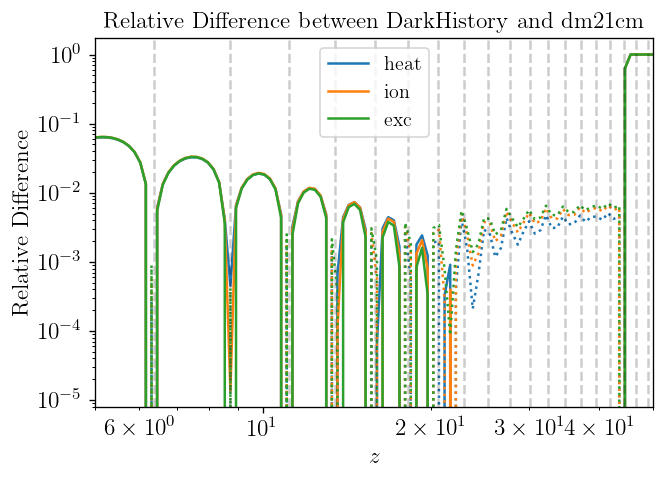

In [12]:
diffs = {}
for k in ['heat', 'ion', 'exc']:
    if k == 'ion':
        dh_fs = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    else:
        dh_fs = dh_soln['f']['low'][k] + dh_soln['f']['high'][k]
    interp_dh = interpolate.interp1d(dh_soln['rs'] - 1, dh_fs, bounds_error=False, fill_value=0.)
    interp_dm21 = interpolate.interp1d(soln['z'], soln[f'f_{k}'], bounds_error=False, fill_value=0.)

    common_x = np.geomspace(5, 50, 100)  # you can adjust the number of points
    common_dh = interp_dh(common_x)
    common_dm21 = interp_dm21(common_x)
    diffs.update({k : (common_dh - common_dm21) / common_dh})

fig, ax = plt.subplots()
for i, k in enumerate(diffs):
    ax.plot(common_x, diffs[k], label=k, color=f'C{i}')
    ax.plot(common_x, -diffs[k], ls=':', color=f'C{i}')
for rs in abscs['rs']:
    ax.axvline(rs-1, ls='--', color='k', alpha=0.2)
ax.set(xlim=(5, 50), xscale='log', yscale='log')  # adjust scales as needed
ax.set(xlabel='$z$', ylabel='Relative Difference', title='Relative Difference between DarkHistory and dm21cm')
ax.legend()

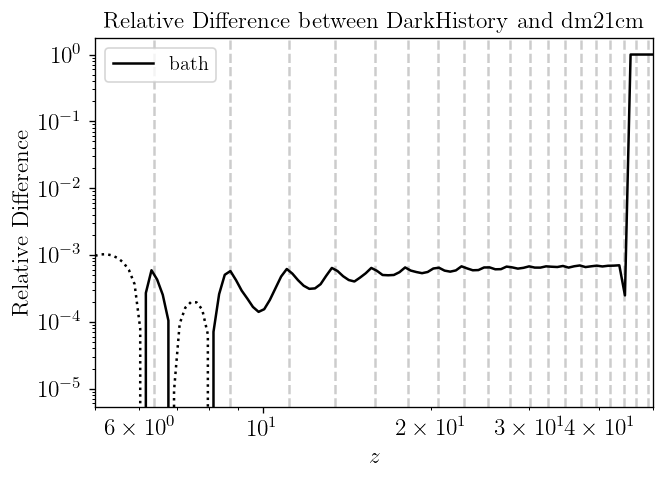

In [13]:
interp_dh = interpolate.interp1d(dh_soln['rs'] - 1, [s.toteng() for s in dh_soln['highengphot']], bounds_error=False, fill_value=0.)
interp_dm21 = interpolate.interp1d(soln['z'], soln['E_phot'], bounds_error=False, fill_value=0.)

common_x = np.geomspace(5, 50, 100)  # you can adjust the number of points
common_dh = interp_dh(common_x)
common_dm21 = interp_dm21(common_x)
diff = (common_dh - common_dm21) / common_dh

fig, ax = plt.subplots()
ax.plot(common_x, diff, label='bath', color=f'k')
ax.plot(common_x, -diff, ls=':', color=f'k')
for rs in abscs['rs']:
    ax.axvline(rs-1, ls='--', color='k', alpha=0.2)
ax.set(xlim=(5, 50), xscale='log', yscale='log')  # adjust scales as needed
ax.set(xlabel='$z$', ylabel='Relative Difference', title='Relative Difference between DarkHistory and dm21cm')
ax.legend()

In [18]:
dh_soln.keys()

dict_keys(['rs', 'x', 'Tm', 'highengphot', 'lowengphot', 'lowengelec', 'f'])

In [ ]:
zs = np.linspace(5.001, 44.999, 100)
dh_fs = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
dh_arr = np.interp(1+zs, dh_soln['rs'][::-1], dh_fs[::-1])
p21c_arr = np.interp(zs, soln['z'][::-1], soln['f_heat'][::-1])
(np.abs(p21c_arr-dh_arr)/dh_arr)

In [ ]:
zs = np.linspace(5.001, 44.999, 100)
dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
dh_arr = np.interp(1+zs, dh_soln['rs'][::-1], dh_bath_engs[::-1])
p21c_arr = np.interp(zs, soln['z'][::-1], soln['E_phot'][::-1])
np.max(np.abs(p21c_arr-dh_arr)/dh_arr)

0.05427165381579362

In [ ]:
plt.plot(zs, p21c_arr)
plt.plot(zs, dh_arr)